In [1]:
import collections
import pandas as pd
import spacy
import textacy
from tqdm import tqdm
import plotly.express as px
spacy.prefer_gpu()

False

In [2]:
df = pd.read_csv("random_train_question_features.csv")

In [3]:
df.head()

,Unnamed: 0,index,text_title,paragraph_text,question_id,question_text,question_token,question_pos,question_tag,question_parse_tree,...,WHP_type,WHP_token,merged_answer_token_index,min_answer_len,max_answer_len,index.1,counter_answer,counter_unique_ answer,contains_ner,contains_ner_type
0,0,0,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"['When', 'did', 'Beyonce', 'start', 'becoming'...","['ADV', 'AUX', 'PROPN', 'VERB', 'VERB', 'ADJ',...","['WRB', 'VBD', 'NNP', 'VB', 'VBG', 'JJ', '.']",(ROOT\n (SBARQ\n (WHADVP (WRB When))\n ...,...,WHADVP,When,"{(56, 60)}",4,4,0,1,1,True,"{'', 'DATE'}"
1,1,1,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"['What', 'areas', 'did', 'Beyonce', 'compete',...","['DET', 'NOUN', 'AUX', 'PROPN', 'VERB', 'ADP',...","['WDT', 'NNS', 'VBD', 'NNP', 'VB', 'RP', 'WRB'...",(ROOT\n (FRAG\n (SBAR\n (WHNP (WDT Wh...,...,WHNP,What,"{(44, 47)}",3,3,1,1,1,False,{''}
2,2,2,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"['When', 'did', 'Beyonce', 'leave', 'Destiny',...","['ADV', 'AUX', 'PROPN', 'VERB', 'PROPN', 'PART...","['WRB', 'VBD', 'NNP', 'VB', 'NNP', 'POS', 'NNP...",(ROOT\n (SBARQ\n (WHADVP (WRB When))\n ...,...,WHADVP,When,"{(112, 113)}",1,1,2,1,1,True,{'DATE'}
3,3,3,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"['In', 'what', 'city', 'and', 'state', 'did', ...","['ADP', 'PRON', 'NOUN', 'CCONJ', 'NOUN', 'AUX'...","['IN', 'WP', 'NN', 'CC', 'NN', 'VBD', 'NNP', '...",(ROOT\n (SBARQ\n (WHPP\n (IN In)\n ...,...,WHPP,In what city and state,"{(36, 39)}",3,3,3,1,1,True,"{'GPE', ''}"
4,4,4,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"['In', 'which', 'decade', 'did', 'Beyonce', 'b...","['ADP', 'DET', 'NOUN', 'AUX', 'PROPN', 'VERB',...","['IN', 'WDT', 'NN', 'VBD', 'NNP', 'VB', 'JJ', ...",(ROOT\n (SBARQ\n (WHPP (IN In) (WHNP (WDT ...,...,WHPP,In which decade,"{(58, 60)}",2,2,4,1,1,True,{'DATE'}


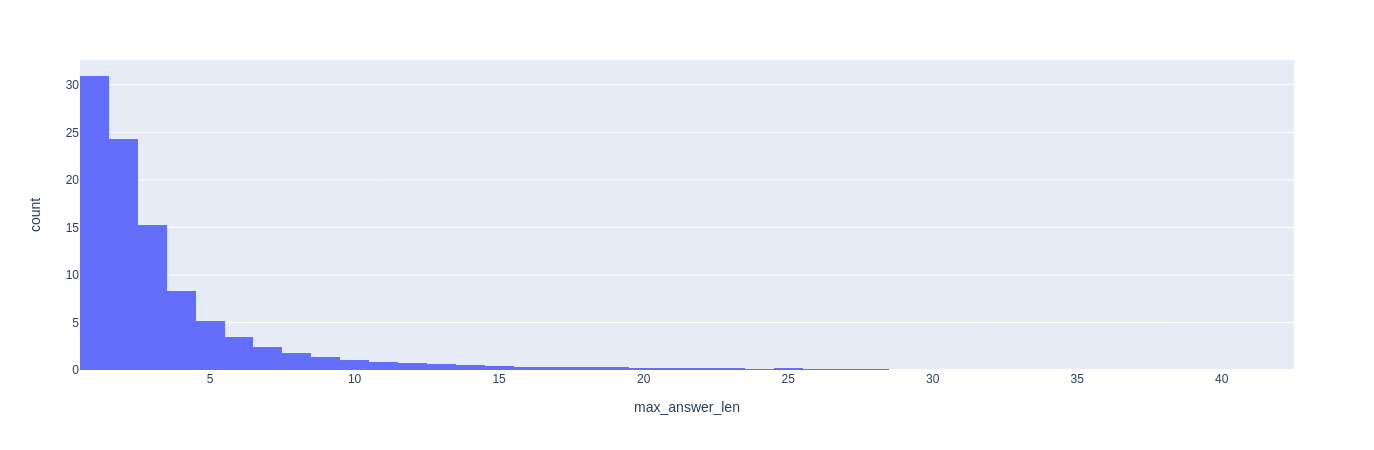

In [5]:
px.histogram(df, "max_answer_len", histnorm="percent")

In [9]:
def token_ngram_counter(gram_spans):
    return [tuple(t.text.lower() for t in gram_span) for gram_span in gram_spans]

def first_token_ngram_counter(gram_spans):
    return [tuple(t.text.lower() for t in gram_spans[0])]

def pos_ngram_counter(gram_spans):
    return [tuple(t.pos_ for t in gram_span) for gram_span in gram_spans]

def first_pos_ngram_counter(gram_spans):
    return [tuple(t.pos_ for t in gram_spans[0])]

def tag_ngram_counter(gram_spans):
    return [tuple(t.tag_ for t in gram_span) for gram_span in gram_spans]

def first_tag_ngram_counter(gram_spans):
    return [tuple(t.tag_ for t in gram_spans[0])]

def ent_ngram_counter(gram_spans):
    return [tuple(t.ent_type_ for t in gram_span) for gram_span in gram_spans]

def first_ent_ngram_counter(gram_spans):
    return [tuple(t.ent_type_ for t in gram_spans[0])]

def contains_ner(all_answer_docs):
    result_set = set()
    for answer_doc in all_answer_docs:
        result_set.update([token.ent_iob_ for token in answer_doc])
    
    return result_set != set('O')
    
def contains_ner_type(all_answer_docs):
    result_set = set()
    for answer_doc in all_answer_docs:
        #print([token.text for token in answer_doc], "--->", [token.ent_type_ for token in answer_doc])
        result_set.update([token.ent_type_ for token in answer_doc])
    result_set.discard('')
    return result_set

In [10]:
nlp = spacy.load("en_core_web_sm")
counter_dict = collections.defaultdict(collections.Counter)

for i, row in tqdm(df.iterrows()):
    counter_dict["counter_answer"].update([("{}".format(len(row["correct_answer_text"])),)])
    counter_dict["counter_unique_ answer"].update([("{}".format(len(set(row["correct_answer_text"])),)])
    paragraph_context = nlp(row["paragraph_text"])
    all_answer_docs = []
    for start, end in row["correct_answer_token_index"]:
        all_answer_docs.append(paragraph_context[start:end])
    counter_dict["contains_ner"].update([("{}".format(contains_ner(all_answer_docs)),)])
    counter_dict["contains_ner_type"].update([("{}".format(contains_ner_type(all_answer_docs)),)])
    for answer_doc in all_answer_docs:
        for i in range(1,3):
            gram_spans = list(textacy.extract.ngrams(answer_doc, i, filter_stops=False))
            
            if len(gram_spans)>0:
                counter_dict["counter_{}".format(i)].update(token_ngram_counter(gram_spans))
                counter_dict["first_counter_{}".format(i)].update(first_token_ngram_counter(gram_spans))

                counter_dict["pos_counter_{}".format(i)].update(pos_ngram_counter(gram_spans))
                counter_dict["first_pos_counter_{}".format(i)].update(first_pos_ngram_counter(gram_spans))

                counter_dict["tag_counter_{}".format(i)].update(tag_ngram_counter(gram_spans))
                counter_dict["first_tag_counter_{}".format(i)].update(first_tag_ngram_counter(gram_spans))

                counter_dict["ner_counter_{}".format(i)].update(ent_ngram_counter(gram_spans))
                counter_dict["first_ner_counter_{}".format(i)].update(first_ent_ngram_counter(gram_spans))

53263it [26:08, 33.96it/s]


In [11]:
import os

if not os.path.exists("images"):
    os.mkdir("images")
    
if not os.path.exists("images/answers"):
    os.mkdir("images/answers")

In [12]:
import plotly.express as px
for key in counter_dict.keys():
    df_counter = pd.DataFrame(data=counter_dict[key].most_common(25), columns=["value_tuple", "count"])
    df_counter["value"] = [" ".join(t) for t in df_counter["value_tuple"]]

    fig = px.bar(df_counter, x="value", y="count", log_y=False, title=key)
    
    fig.write_image("images/answers/{}.png".format(key))